# Description

This notebooks performs QA checks for a single vendor:
   - Number of NaN data points as % of total
   - Number of data points where `volume=0` as % of total

# Imports

In [1]:
import logging
import os

import pandas as pd

import core.config.config_ as cconconf
import core.config.config_utils as ccocouti
import core.statistics as costatis
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import helpers.hs3 as hs3
import im_v2.ccxt.data.client as icdcl
import im_v2.common.data.client as icdc
import im_v2.crypto_chassis.data.client.crypto_chassis_clients as imvccdcccc

/app/helpers/hparquet.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-fa7e309c-9041-49b7-a7db-5866c4cbc54c.json'
INFO  # Git
    branch_name='CMTask1945_CryptoChassis_QA'
    hash='9ffd55de2'
    # Last commits:
      * 9ffd55de2 Daniil Tikhomirov CMTask1951: Update setUp and tearDown for market data tests (#1965) (82 minutes ago) Fri May 20 15:09:56 2022  (HEAD -> CMTask1945_CryptoChassis_QA, origin/master, origin/HEAD, master)
      * 9f9293619 DanilYachmenev Cm task1944 read crypto chassis data (#1962)                      (  16 hours ago) Fri May 20 00:52:39 2022  (origin/CMTask1948_coinbase_pro_data)
      * fd33c10ef Nina Lee CMTask1920: change paths for the clients (#1946)                  (  19 hours ago) Thu May 19 21:22:15 2022           
# Machine info
    system=Linux
    node name=5324de535407
    release=5.13.0-1022-aws
    version=#24~20.04.1-Ubuntu SMP Thu Apr 7 22:10:15 UTC 2022
    machine=x86_64
    processor=x86_64
    cpu

# Configs

In [3]:
def get_cmtask1866_config_ccxt() -> cconconf.Config:
    """
    Get task1866-specific config.
    """
    config = cconconf.Config()
    param_dict = {
        "data": {
            # Parameters for client initialization.
            "im_client": {
                "universe_version": "v1",
                "resample_1min": True,
                "root_dir": os.path.join(
                    hs3.get_s3_bucket_path("ck"),
                    "reorg",
                    "historical.manual.pq",
                ),
                "partition_mode": "by_year_month",
                "data_snapshot": "latest",
                "aws_profile": "ck",
            },
            # Parameters for data query.
            "read_data": {
                "start_ts": None,
                "end_ts": None,
                "columns": None,
                "filter_data_mode": "assert",
            },
        },
        "column_names": {
            "full_symbol": "full_symbol",
            "close_price": "close",
        },
        "stats": {
            "threshold": 30,
        },
    }
    config = cconfig.Config.from_dict(param_dict)
    return config

In [4]:
config = get_cmtask1866_config_ccxt()
print(config)

data:
  im_client:
    universe_version: v1
    resample_1min: True
    root_dir: s3://cryptokaizen-data/reorg/historical.manual.pq
    partition_mode: by_year_month
    data_snapshot: latest
    aws_profile: ck
  read_data:
    start_ts: None
    end_ts: None
    columns: None
    filter_data_mode: assert
column_names:
  full_symbol: full_symbol
  close_price: close
stats:
  threshold: 30


# Functions

In [5]:
# TODO(Dan): Clean up and move to a lib.
# TODO(Dan): Separate data reading and computing the stats.
def perform_qa_per_exchange(
    config: cconconf.Config,
    exchange_id: str,
    client: icdc.ImClient,
    *,
    by_year_month: bool = False,
) -> pd.DataFrame:
    """
    Get quality assurance stats for specified exchange.

    QA stats include:
       - % of NaNs
       - % of rows with "volume=0"
       - % of bad data which is the sum of NaNs and "volume=0" stats
       - min and max timestamp if `by_year_month=False`

    E.g.,
    ```
                                    NaNs [%]  volume=0 [%]  bad data [%]
    full_symbol        year  month
    binance::ADA_USDT  2022      1    0.2222        0.2222        0.4444
                                 2       5.9           0.1           6.0
    binance::BTC_USDT  2022      1       0.0           0.0           0.0
    ```
    :param config: parameters config
    :param exchange_id: name of exchange to compute stats for
    :param client: client to read data
    :param by_year_month: compute QA stats by year and month
    """
    # Get exchange data for related full symbols.
    universe = client.get_universe()
    exchange_universe = [
        full_symbol
        for full_symbol in universe
        if full_symbol.startswith(exchange_id)
    ]
    exchange_data = client.read_data(
        exchange_universe, **config["data"]["read_data"]
    )
    # Compute exchange stats.
    if by_year_month:
        qa_stats = _get_qa_stats_by_year_month(config, exchange_data)
    else:
        qa_stats = _get_qa_stats(config, exchange_data)
    return qa_stats


# TODO(Dan): Merge with `_get_qa_stats_by_year_month()` by passing `agg_level`.
def _get_qa_stats(config: cconconf.Config, data: pd.DataFrame) -> pd.DataFrame:
    """
    Get quality assurance stats per full symbol.
    """
    res_stats = []
    for full_symbol, symbol_data in data.groupby(
        config["column_names"]["full_symbol"]
    ):
        # Compute stats for a full symbol.
        symbol_stats = pd.Series(dtype="object", name=full_symbol)
        symbol_stats["min_timestamp"] = symbol_data.index.min()
        symbol_stats["max_timestamp"] = symbol_data.index.max()
        symbol_stats["NaNs [%]"] = 100 * (
            costatis.compute_frac_nan(
                symbol_data[config["column_names"]["close_price"]]
            )
        )
        symbol_stats["volume=0 [%]"] = 100 * (
            symbol_data[symbol_data["volume"] == 0].shape[0]
            / symbol_data.shape[0]
        )
        symbol_stats["bad data [%]"] = (
            symbol_stats["NaNs [%]"] + symbol_stats["volume=0 [%]"]
        )
        res_stats.append(symbol_stats)
    # Combine all full symbol stats.
    res_stats_df = pd.concat(res_stats, axis=1).T
    return res_stats_df


def _get_qa_stats_by_year_month(
    config: cconconf.Config, data: pd.DataFrame
) -> pd.DataFrame:
    """
    Get quality assurance stats per full symbol, year, and month.
    """
    # Get year and month columns to group by them.
    data["year"] = data.index.year
    data["month"] = data.index.month
    #
    res_stats = []
    for index, data_monthly in data.groupby(["year", "month"]):
        #
        year, month = index
        #
        stats_monthly = _get_qa_stats(config, data_monthly)
        #
        stats_monthly["year"] = year
        stats_monthly["month"] = month
        res_stats.append(stats_monthly)
    res_stats_df = pd.concat(res_stats)
    res_stats_df = res_stats_df.drop(["min_timestamp", "max_timestamp"], axis=1)
    #
    # Set index by full symbol, year, and month.
    res_stats_df[config["column_names"]["full_symbol"]] = res_stats_df.index
    index_columns = [config["column_names"]["full_symbol"], "year", "month"]
    res_stats_df = res_stats_df.sort_values(index_columns)
    res_stats_df = res_stats_df.set_index(index_columns)
    return res_stats_df


# TODO(Dan): Add filtering by dates.
def _plot_bad_data_stats(
    config: cconconf.Config, bad_data_stats: pd.DataFrame
) -> None:
    """
    Plot bad data stats per unique full symbol in data.

    Bad data is the sum of NaNs and "volume=0" stats.
    """
    full_symbols = bad_data_stats.index.get_level_values(0).unique()
    for full_symbol in full_symbols:
        bad_data_col_name = "bad data [%]"
        ax = bad_data_stats.loc[full_symbol].plot.bar(
            y=bad_data_col_name, rot=0, title=full_symbol
        )
        #
        ax.hlines(
            y=config["stats"]["threshold"],
            xmin=0,
            xmax=len(bad_data_stats),
            color="r",
        )
        # TODO(Dan): Make ticklabels more readable.
        # Get ticks and labels for x-axis.
        ticks = ax.xaxis.get_ticklocs()
        ticklabels = [
            l.get_text().strip("()").split(", ")
            for l in ax.xaxis.get_ticklabels()
        ]
        ticklabels = [".".join([l[0], l[1]]) for l in ticklabels]
        # Adjust x-axis labels so they do not overlap on plot by
        # picking ticks and labels by specified stride that limits
        # the number of final ticks to 10.
        stride = len(ticks) // 10 + 1
        ax.xaxis.set_ticks(ticks[::stride])
        ax.xaxis.set_ticklabels(ticklabels[::stride])
        ax.figure.show()

# QA checks

Major metric for a QA check is `"bad data [%]"` which is the sum of `"volume=0 [%]"` and `"NaNs [%]"`.

In [6]:
client = imvccdcccc.CryptoChassisHistoricalPqByTileClient(
    **config["data"]["im_client"]
)

In [7]:
universe = client.get_universe()
universe

['binance::ADA_USDT',
 'binance::BNB_USDT',
 'binance::BTC_USDT',
 'binance::DOGE_USDT',
 'binance::EOS_USDT',
 'binance::ETH_USDT',
 'binance::SOL_USDT',
 'ftx::BNB_USDT',
 'ftx::BTC_USDT',
 'ftx::DOGE_USDT',
 'ftx::ETH_USDT',
 'ftx::SOL_USDT',
 'ftx::XRP_USDT',
 'gateio::BNB_USDT',
 'gateio::BTC_USDT',
 'gateio::DOGE_USDT',
 'gateio::ETH_USDT',
 'gateio::SOL_USDT',
 'gateio::XRP_USDT',
 'kucoin::BNB_USDT',
 'kucoin::BTC_USDT',
 'kucoin::DOGE_USDT',
 'kucoin::ETH_USDT',
 'kucoin::SOL_USDT',
 'kucoin::XRP_USDT']

## Binance

In [8]:
binance_stats = perform_qa_per_exchange(config, "binance", client)
binance_stats

,min_timestamp,max_timestamp,NaNs [%],volume=0 [%],bad data [%]
binance::ADA_USDT,2021-08-07 00:00:00+00:00,2022-05-18 10:05:00+00:00,0.138439,0.0,0.138439
binance::BNB_USDT,2021-08-07 00:00:00+00:00,2022-05-18 10:06:00+00:00,0.136486,0.0,0.136486
binance::BTC_USDT,2018-01-01 00:00:00+00:00,2022-05-18 10:06:00+00:00,0.397745,0.0,0.397745
binance::DOGE_USDT,2021-08-07 00:00:00+00:00,2022-05-18 10:06:00+00:00,0.139904,0.0,0.139904
binance::EOS_USDT,2018-05-28 05:00:00+00:00,2022-05-18 10:06:00+00:00,0.984617,0.0,0.984617
binance::ETH_USDT,2018-01-01 00:00:00+00:00,2022-05-18 10:06:00+00:00,0.434022,0.0,0.434022
binance::SOL_USDT,2021-10-13 17:49:00+00:00,2022-05-18 10:06:00+00:00,0.273382,0.0,0.273382


In [9]:
binance_stats_by_year_month = perform_qa_per_exchange(
    config, "binance", client, by_year_month=True
)
binance_stats_by_year_month

NaNs [%] volume=0 [%] bad data [%]
full_symbol        year month                                     
binance::ADA_USDT  2021 8           0.75          0.0         0.75
                        9       0.395833          0.0     0.395833
                        10      0.208333          0.0     0.208333
                        11      0.002315          0.0     0.002315
                        12      0.071685          0.0     0.071685
                   2022 1            0.0          0.0          0.0
                        2            0.0          0.0          0.0
                        3            0.0          0.0          0.0
                        4            0.0          0.0          0.0
                        5            0.0          0.0          0.0
binance::BNB_USDT  2021 8           0.75          0.0         0.75
                        9       0.393519          0.0     0.393519
                        10      0.192652          0.0     0.192652
                        11      0.002315          0.0     0.002315
                        12      0.071685          0.0     0.071685
                   2022 1            0.0          0.0          0.0
                        2            0.0          0.0          0.0
                        3            0.0          0.0          0.0
                        4            0.0          0.0          0.0
                        5            0.0          0.0          0.0
binance::BTC_USDT  2018 1       0.280018          0.0     0.280018
                        2       5.109127          0.0     5.109127
                        3            0.0          0.0          0.0
                        4            0.0          0.0          0.0
                        5            0.0          0.0          0.0
                        6       1.631944          0.0     1.631944
                        7       1.023746          0.0     1.023746
                        8            0.0          0.0          0.0
                        9            0.0          0.0          0.0
                        10       0.47043          0.0      0.47043
                        11      0.972222          0.0     0.972222
                        12           0.0          0.0          0.0
                   2019 1            0.0          0.0          0.0
                        2            0.0          0.0          0.0
                        3       0.806452          0.0     0.806452
                        4            0.0          0.0          0.0
                        5       1.344086          0.0     1.344086
                        6       0.310185          0.0     0.310185
                        7            0.0          0.0          0.0
                        8       1.075269          0.0     1.075269
                        9            0.0          0.0          0.0
                        10           0.0          0.0          0.0
                        11      0.615741          0.0     0.615741
                        12           0.0          0.0          0.0
                   2020 1            0.0          0.0          0.0
                        2       0.991379          0.0     0.991379
                        3       0.286738          0.0     0.286738
                        4       0.347222          0.0     0.347222
                        5            0.0          0.0          0.0
                        6       0.486111          0.0     0.486111
                        7            0.0          0.0          0.0
                        8            0.0          0.0          0.0
                        9            0.0          0.0          0.0
                        10           0.0          0.0          0.0
                        11      0.138889          0.0     0.138889
                        12      0.698925          0.0     0.698925
                   2021 1           1.25          0.0         1.25
                        2       0.396825          0.0     0.396825
            

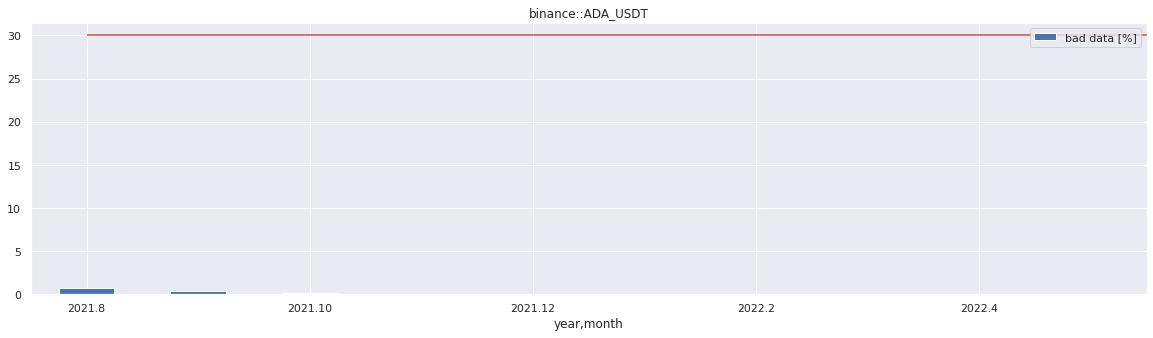

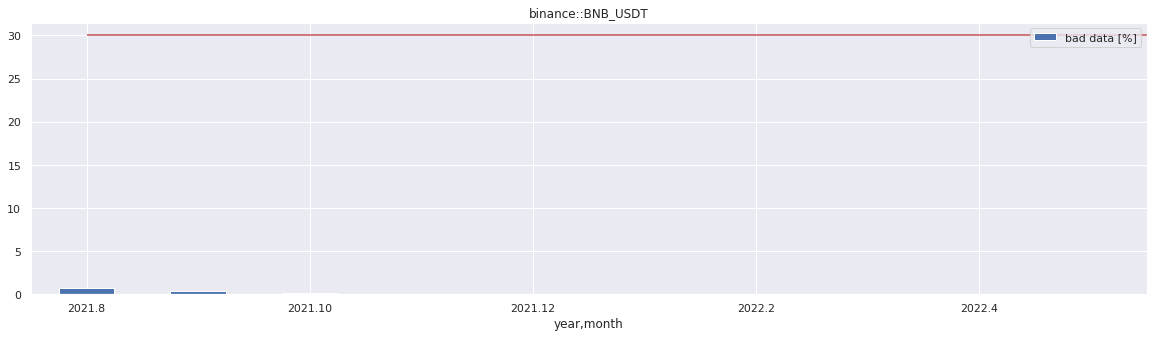

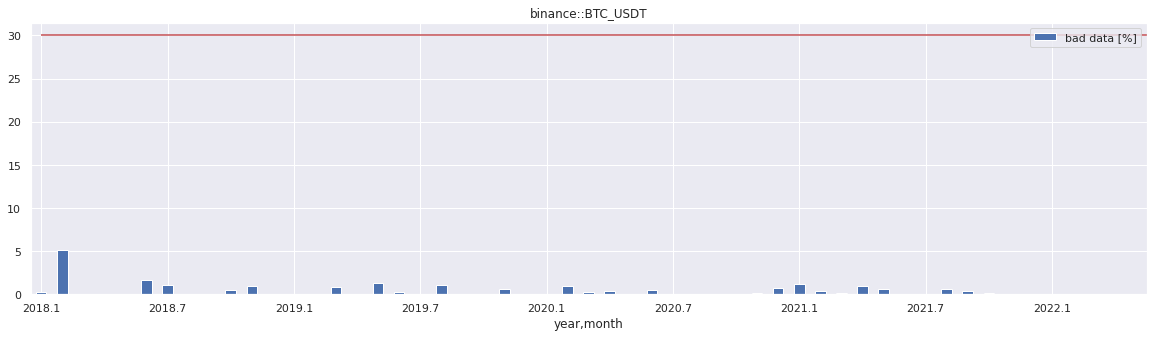

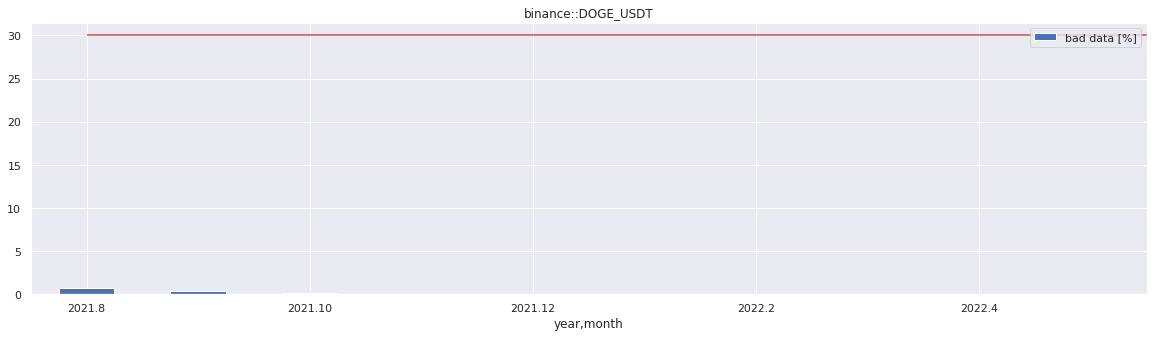

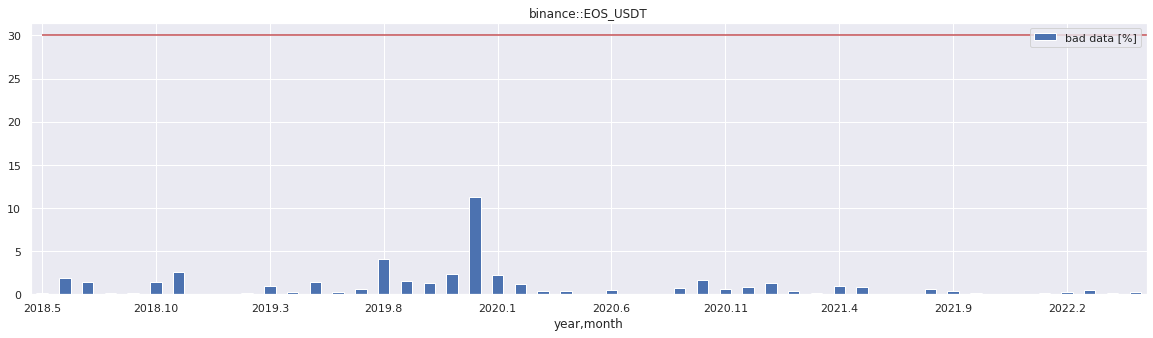

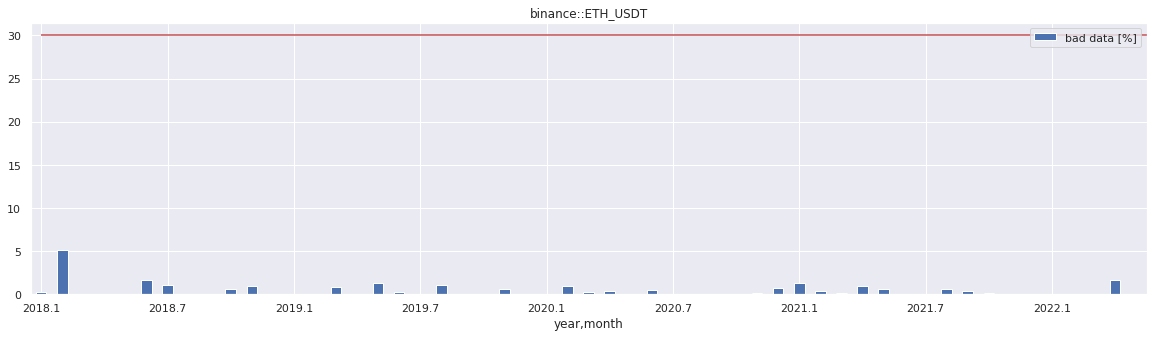

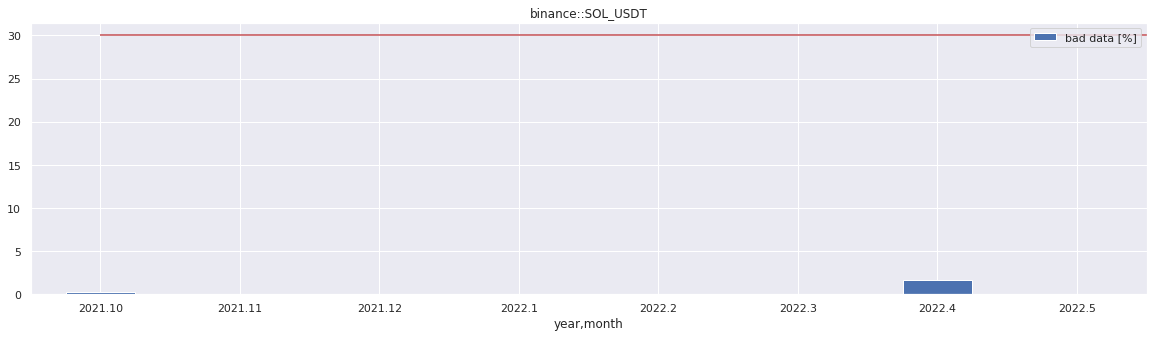

In [10]:
_ = _plot_bad_data_stats(config, binance_stats_by_year_month)

## FTX

In [11]:
ftx_stats = perform_qa_per_exchange(config, "ftx", client)
ftx_stats

,min_timestamp,max_timestamp,NaNs [%],volume=0 [%],bad data [%]
ftx::BNB_USDT,2021-08-07 00:00:00+00:00,2022-05-18 10:03:00+00:00,7.263578,0.0,7.263578
ftx::BTC_USDT,2021-08-07 00:00:00+00:00,2022-05-18 10:04:00+00:00,0.29104,0.0,0.29104
ftx::DOGE_USDT,2021-08-07 00:00:00+00:00,2022-05-18 10:04:00+00:00,25.844005,0.0,25.844005
ftx::ETH_USDT,2021-08-07 00:00:00+00:00,2022-05-18 10:04:00+00:00,0.783758,0.0,0.783758
ftx::SOL_USDT,2021-10-13 17:49:00+00:00,2022-05-18 10:04:00+00:00,4.501372,0.0,4.501372
ftx::XRP_USDT,2021-08-07 00:00:00+00:00,2022-05-18 10:03:00+00:00,20.0042,0.0,20.0042


In [12]:
ftx_stats_by_year_month = perform_qa_per_exchange(
    config, "ftx", client, by_year_month=True
)
ftx_stats_by_year_month

NaNs [%] volume=0 [%] bad data [%]
full_symbol    year month                                     
ftx::BNB_USDT  2021 8       5.663889          0.0     5.663889
                    9       9.527778          0.0     9.527778
                    10      4.926075          0.0     4.926075
                    11      0.826389          0.0     0.826389
                    12      3.828405          0.0     3.828405
               2022 1       9.173387          0.0     9.173387
                    2      10.763889          0.0    10.763889
                    3       7.934588          0.0     7.934588
                    4       10.43287          0.0     10.43287
                    5      11.341891          0.0    11.341891
ftx::BTC_USDT  2021 8       0.333333          0.0     0.333333
                    9       0.333333          0.0     0.333333
                    10      0.268817          0.0     0.268817
                    11      0.034722          0.0     0.034722
                    12      0.147849          0.0     0.147849
               2022 1       0.188172          0.0     0.188172
                    2       0.438988          0.0     0.438988
                    3       0.284498          0.0     0.284498
                    4       0.717593          0.0     0.717593
                    5       0.115607          0.0     0.115607
ftx::DOGE_USDT 2021 8       4.313889          0.0     4.313889
                    9      14.310185          0.0    14.310185
                    10     14.854391          0.0    14.854391
                    11     10.425926          0.0    10.425926
                    12      20.46371          0.0     20.46371
               2022 1      32.715054          0.0    32.715054
                    2      47.978671          0.0    47.978671
                    3      54.641577          0.0    54.641577
                    4      31.993056          0.0    31.993056
                    5         22.647          0.0       22.647
ftx::ETH_USDT  2021 8       1.230556          0.0     1.230556
                    9        0.68287          0.0      0.68287
                    10      0.616039          0.0     0.616039
                    11      0.162037          0.0     0.162037
                    12      0.271057          0.0     0.271057
               2022 1       0.521953          0.0     0.521953
                    2       0.820933          0.0     0.820933
                    3       0.974462          0.0     0.974462
                    4       1.946759          0.0     1.946759
                    5        0.66175          0.0      0.66175
ftx::SOL_USDT  2021 10      2.179453          0.0     2.179453
                    11      0.796296          0.0     0.796296
                    12      3.705197          0.0     3.705197
               2022 1       6.810036          0.0     6.810036
                    2       5.114087          0.0     5.114087
                    3       8.967294          0.0     8.967294
                    4       5.011574          0.0     5.011574
                    5       0.813235          0.0     0.813235
ftx::XRP_USDT  2021 8      11.302778          0.0    11.302778
                    9       9.668981          0.0     9.668981
                    10     12.876344          0.0    12.876344
                    11     10.465278          0.0    10.465278
                    12     17.766577          0.0    17.766577
               2022 1      28.019713          0.0    28.019713
                    2      29.821429          0.0    29.821429
                    3      24.399642          0.0    24.399642
                    4      34.856481          0.0    34.856481
                    5      19.940998          0.0    19.940998

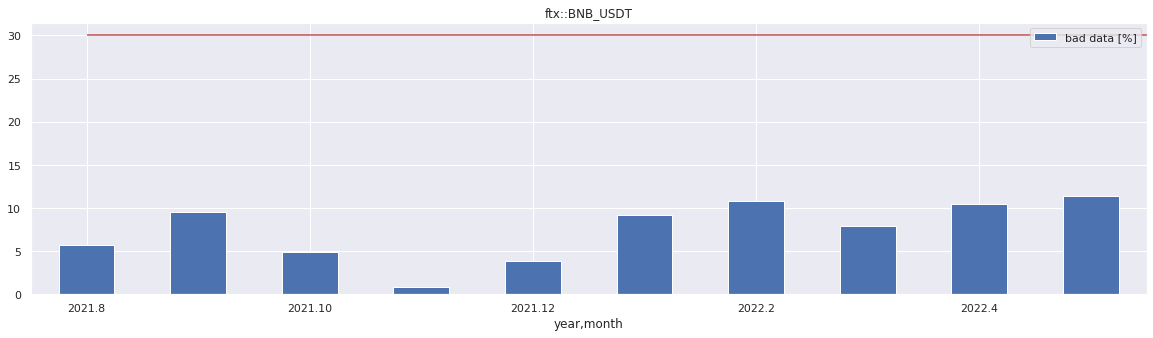

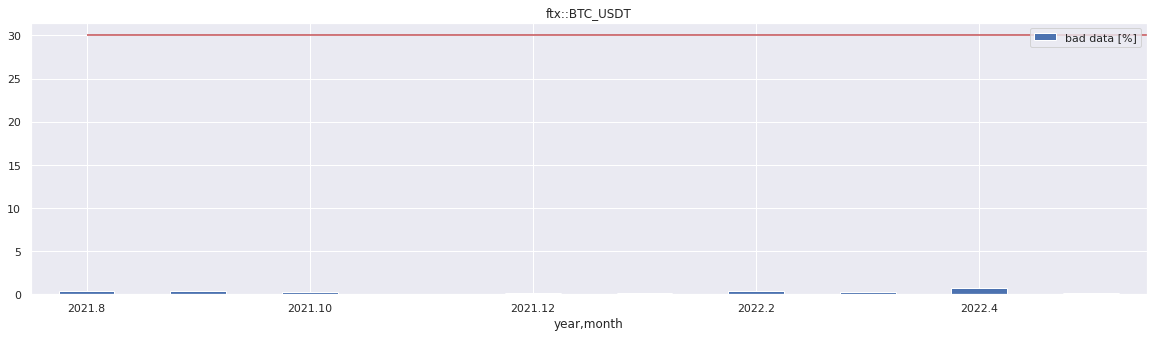

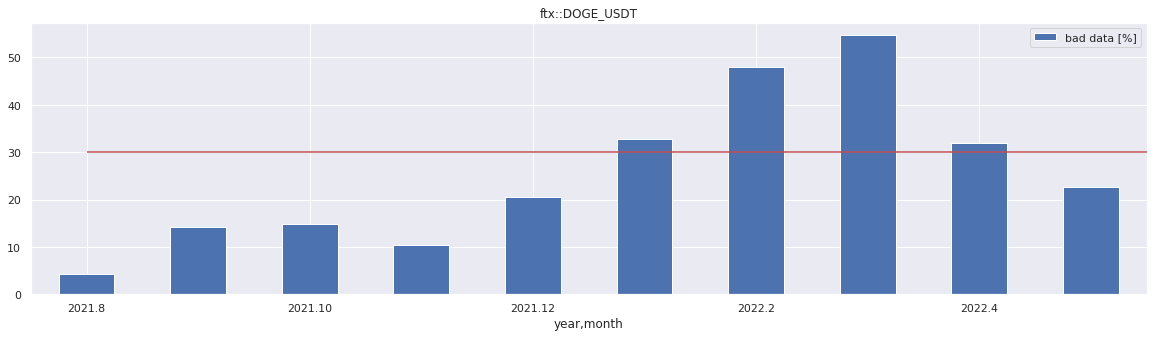

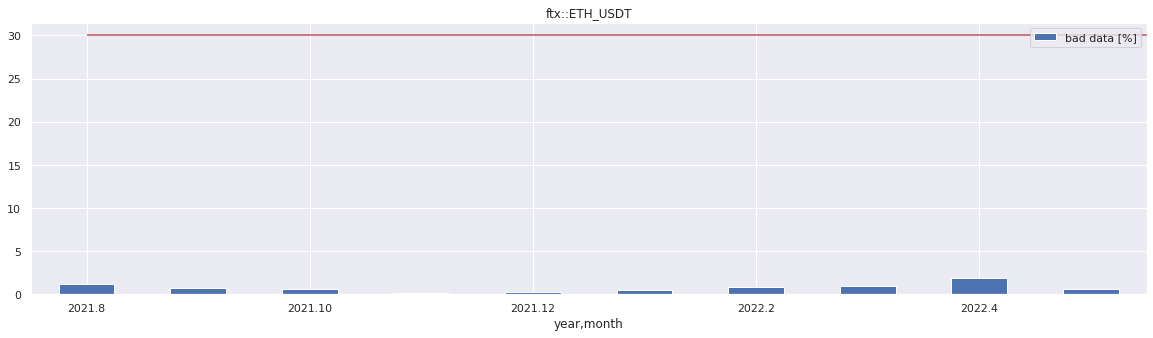

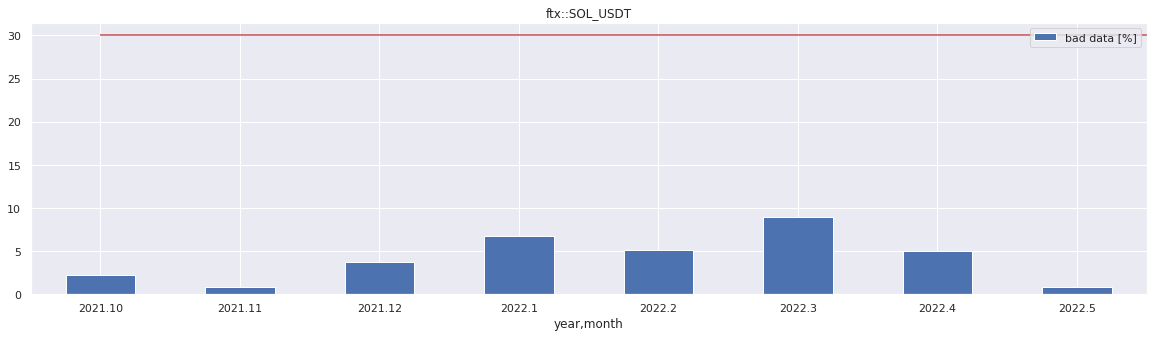

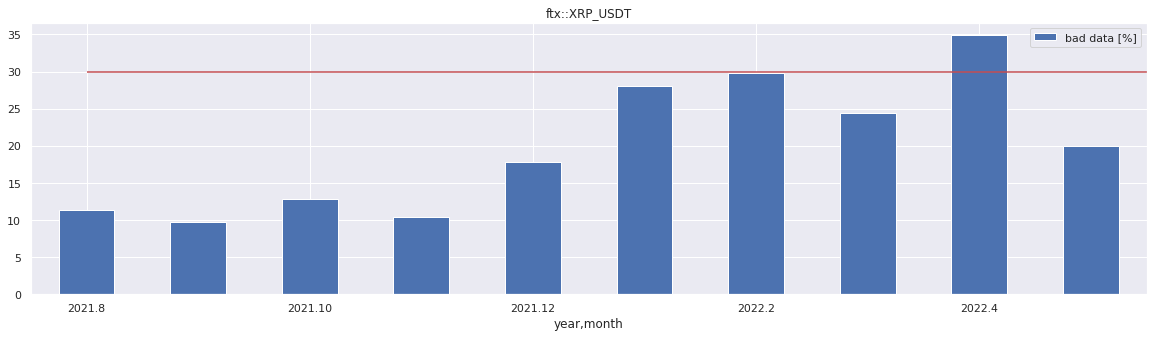

In [13]:
_ = _plot_bad_data_stats(config, ftx_stats_by_year_month)

## Gateio

In [14]:
gateio_stats = perform_qa_per_exchange(config, "gateio", client)
gateio_stats

,min_timestamp,max_timestamp,NaNs [%],volume=0 [%],bad data [%]
gateio::BNB_USDT,2021-10-12 04:07:00+00:00,2022-05-18 10:09:00+00:00,0.359549,0.0,0.359549
gateio::BTC_USDT,2021-10-12 04:08:00+00:00,2022-05-18 10:09:00+00:00,0.342368,0.0,0.342368
gateio::DOGE_USDT,2021-10-12 04:07:00+00:00,2022-05-18 10:09:00+00:00,0.364003,0.0,0.364003
gateio::ETH_USDT,2021-10-12 04:08:00+00:00,2022-05-18 10:09:00+00:00,0.094819,0.0,0.094819
gateio::SOL_USDT,2021-10-13 17:49:00+00:00,2022-05-18 10:08:00+00:00,1.706301,0.0,1.706301
gateio::XRP_USDT,2021-10-12 04:08:00+00:00,2022-05-18 10:09:00+00:00,0.496688,0.0,0.496688


In [15]:
gateio_stats_by_year_month = perform_qa_per_exchange(
    config, "gateio", client, by_year_month=True
)
gateio_stats_by_year_month

NaNs [%] volume=0 [%] bad data [%]
full_symbol       year month                                    
gateio::BNB_USDT  2021 10     0.287185          0.0     0.287185
                       11     0.076389          0.0     0.076389
                       12     0.008961          0.0     0.008961
                  2022 1      0.013441          0.0     0.013441
                       2      0.047123          0.0     0.047123
                       3      0.450269          0.0     0.450269
                       4      1.763889          0.0     1.763889
                       5       0.09167          0.0      0.09167
gateio::BTC_USDT  2021 10     0.301205          0.0     0.301205
                       11     0.078704          0.0     0.078704
                       12     0.040323          0.0     0.040323
                  2022 1      0.011201          0.0     0.011201
                       2      0.024802          0.0     0.024802
                       3      0.396505          0.0     0.396505
                       4      1.724537          0.0     1.724537
                       5      0.003986          0.0     0.003986
gateio::DOGE_USDT 2021 10     0.297692          0.0     0.297692
                       11     0.217593          0.0     0.217593
                       12     0.248656          0.0     0.248656
                  2022 1      0.047043          0.0     0.047043
                       2      0.803571          0.0     0.803571
                       3      0.710125          0.0     0.710125
                       4       0.24537          0.0      0.24537
                       5      0.342766          0.0     0.342766
gateio::ETH_USDT  2021 10     0.304707          0.0     0.304707
                       11     0.071759          0.0     0.071759
                       12     0.067204          0.0     0.067204
                  2022 1      0.008961          0.0     0.008961
                       2       0.00248          0.0      0.00248
                       3      0.324821          0.0     0.324821
                       4           0.0          0.0          0.0
                       5           0.0          0.0          0.0
gateio::SOL_USDT  2021 10     0.513484          0.0     0.513484
                       11     1.289352          0.0     1.289352
                       12     1.050627          0.0     1.050627
                  2022 1      0.642921          0.0     0.642921
                       2      2.318948          0.0     2.318948
                       3      1.449373          0.0     1.449373
                       4      4.488426          0.0     4.488426
                       5      1.414963          0.0     1.414963
gateio::XRP_USDT  2021 10     0.297702          0.0     0.297702
                       11     0.108796          0.0     0.108796
                       12     0.056004          0.0     0.056004
                  2022 1      0.136649          0.0     0.136649
                       2      0.250496          0.0     0.250496
                       3      0.611559          0.0     0.611559
                       4      2.055556          0.0     2.055556
                       5      0.322838          0.0     0.322838

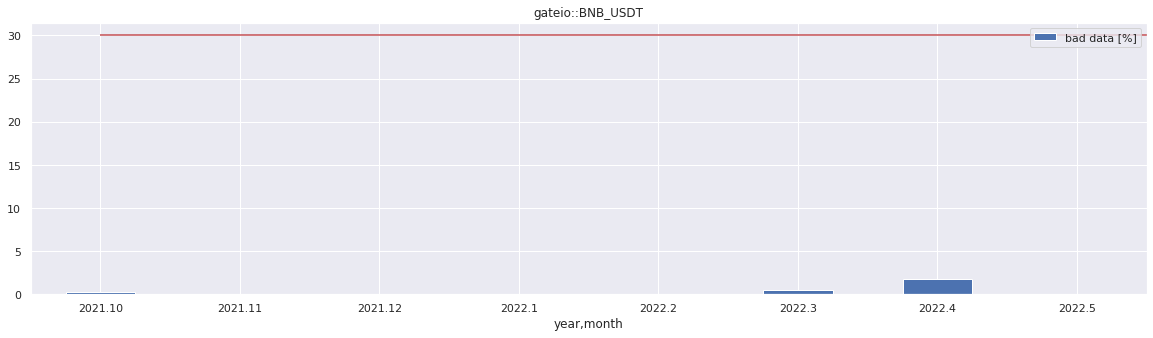

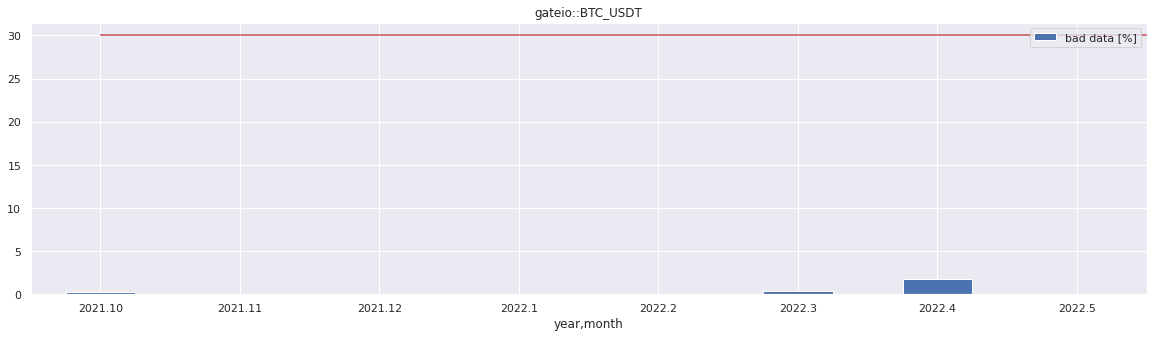

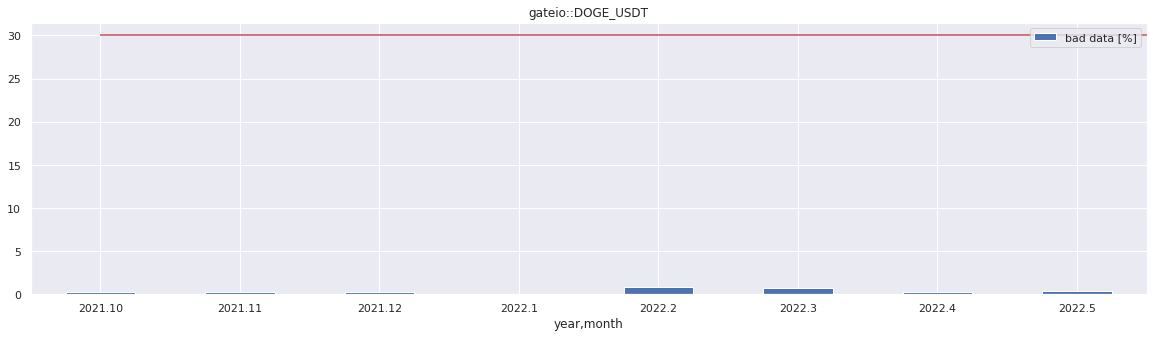

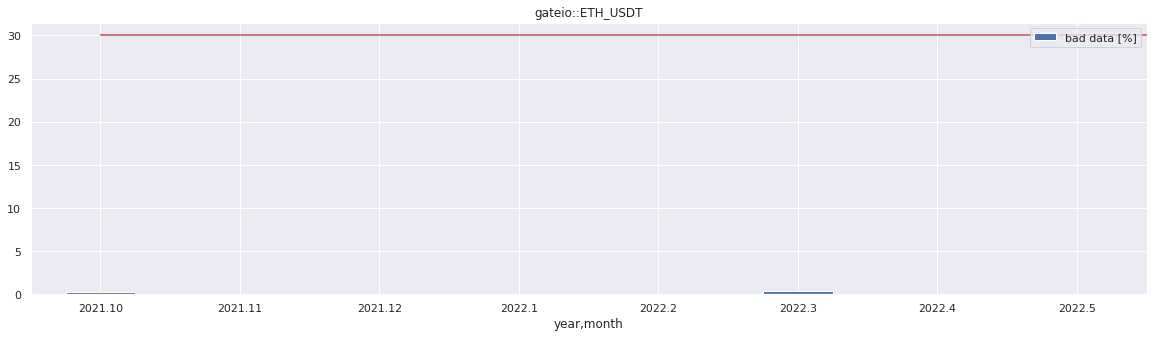

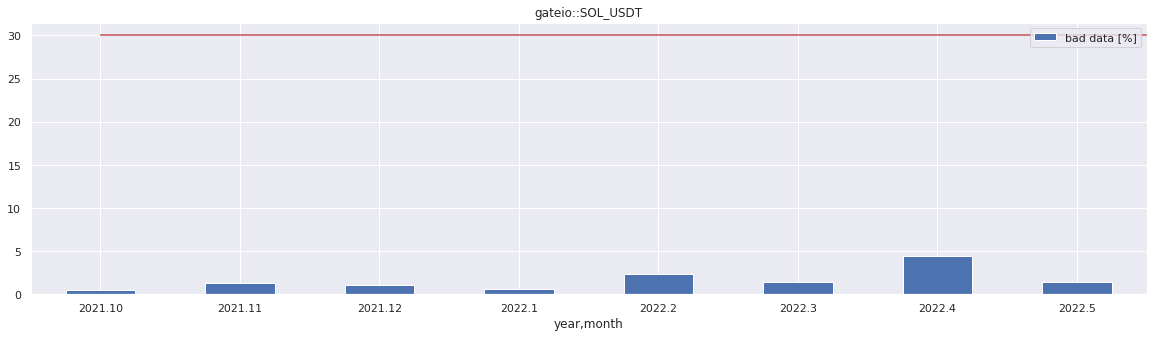

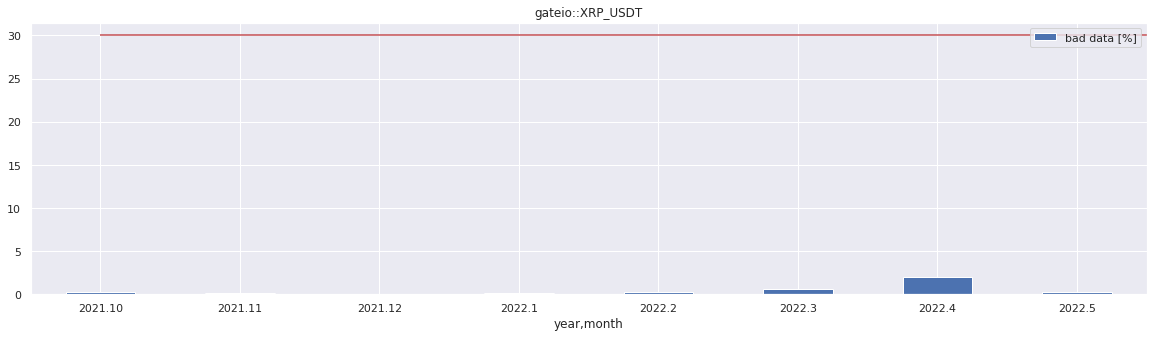

In [16]:
_ = _plot_bad_data_stats(config, gateio_stats_by_year_month)

## Kucoin

In [17]:
kucoin_stats = perform_qa_per_exchange(config, "kucoin", client)
kucoin_stats

,min_timestamp,max_timestamp,NaNs [%],volume=0 [%],bad data [%]
kucoin::BNB_USDT,2021-08-07 00:00:00+00:00,2022-05-18 09:58:00+00:00,0.294219,0.0,0.294219
kucoin::BTC_USDT,2021-08-07 00:00:00+00:00,2022-05-18 09:59:00+00:00,1.08995,0.0,1.08995
kucoin::DOGE_USDT,2021-08-07 00:00:00+00:00,2022-05-18 09:58:00+00:00,1.065781,0.0,1.065781
kucoin::ETH_USDT,2021-08-07 00:00:00+00:00,2022-05-18 09:59:00+00:00,0.105235,0.0,0.105235
kucoin::SOL_USDT,2021-10-13 17:49:00+00:00,2022-05-18 09:59:00+00:00,0.342937,0.0,0.342937
kucoin::XRP_USDT,2021-08-07 00:00:00+00:00,2022-05-18 09:59:00+00:00,0.096933,0.0,0.096933


In [18]:
kucoin_stats_by_year_month = perform_qa_per_exchange(
    config, "kucoin", client, by_year_month=True
)
kucoin_stats_by_year_month

NaNs [%] volume=0 [%] bad data [%]
full_symbol       year month                                    
kucoin::BNB_USDT  2021 8         0.025          0.0        0.025
                       9      0.277778          0.0     0.277778
                       10     0.300179          0.0     0.300179
                       11     0.002315          0.0     0.002315
                       12     0.201613          0.0     0.201613
                  2022 1      0.103047          0.0     0.103047
                       2      0.116567          0.0     0.116567
                       3      0.017921          0.0     0.017921
                       4      1.724537          0.0     1.724537
                       5      0.019937          0.0     0.019937
kucoin::BTC_USDT  2021 8      1.669444          0.0     1.669444
                       9      6.627315          0.0     6.627315
                       10     0.212814          0.0     0.212814
                       11     0.002315          0.0     0.002315
                       12     0.199373          0.0     0.199373
                  2022 1      0.091846          0.0     0.091846
                       2      0.096726          0.0     0.096726
                       3           0.0          0.0          0.0
                       4      1.701389          0.0     1.701389
                       5           0.0          0.0          0.0
kucoin::DOGE_USDT 2021 8      1.680556          0.0     1.680556
                       9      6.733796          0.0     6.733796
                       10     0.275538          0.0     0.275538
                       11      0.00463          0.0      0.00463
                       12     0.300179          0.0     0.300179
                  2022 1      0.748208          0.0     0.748208
                       2      0.590278          0.0     0.590278
                       3       0.00448          0.0      0.00448
                       4           0.0          0.0          0.0
                       5      0.071773          0.0     0.071773
kucoin::ETH_USDT  2021 8      0.008333          0.0     0.008333
                       9      0.256944          0.0     0.256944
                       10     0.262097          0.0     0.262097
                       11          0.0          0.0          0.0
                       12     0.241935          0.0     0.241935
                  2022 1      0.116487          0.0     0.116487
                       2      0.099206          0.0     0.099206
                       3           0.0          0.0          0.0
                       4           0.0          0.0          0.0
                       5           0.0          0.0          0.0
kucoin::SOL_USDT  2021 10     0.391769          0.0     0.391769
                       11      0.00463          0.0      0.00463
                       12     0.210573          0.0     0.210573
                  2022 1      0.103047          0.0     0.103047
                       2      0.116567          0.0     0.116567
                       3      0.094086          0.0     0.094086
                       4      1.701389          0.0     1.701389
                       5      0.003987          0.0     0.003987
kucoin::XRP_USDT  2021 8      0.011111          0.0     0.011111
                       9      0.256944          0.0     0.256944
                       10     0.197133          0.0     0.197133
                       11     0.002315          0.0     0.002315
                       12     0.203853          0.0     0.203853
                  2022 1      0.098566          0.0     0.098566
                       2      0.106647          0.0     0.106647
                       3       0.00448          0.0      0.00448
                       4      0.030093          0.0     0.030093
                       5           0.0          0.0          0.0

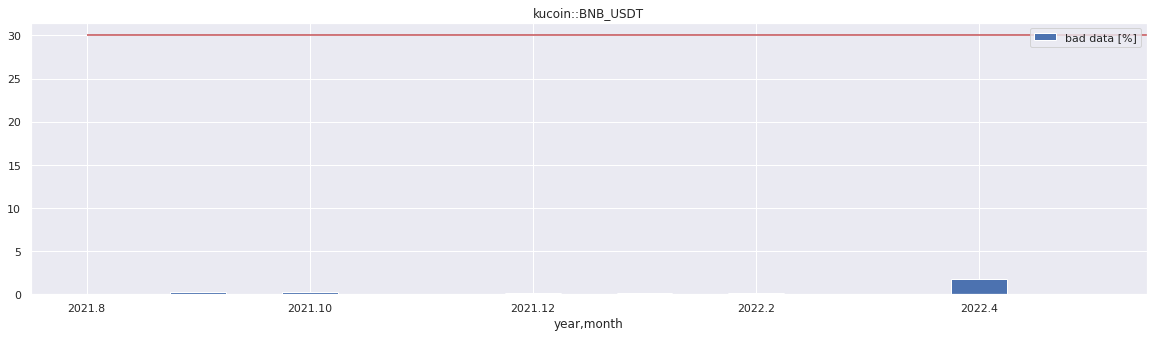

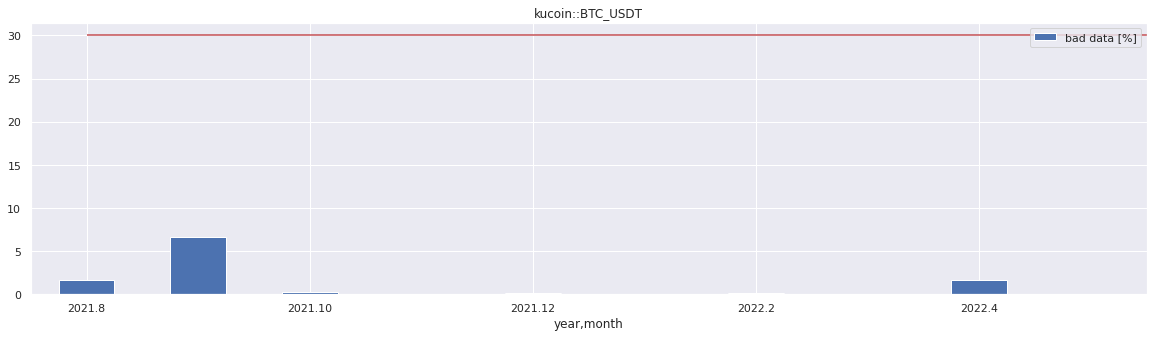

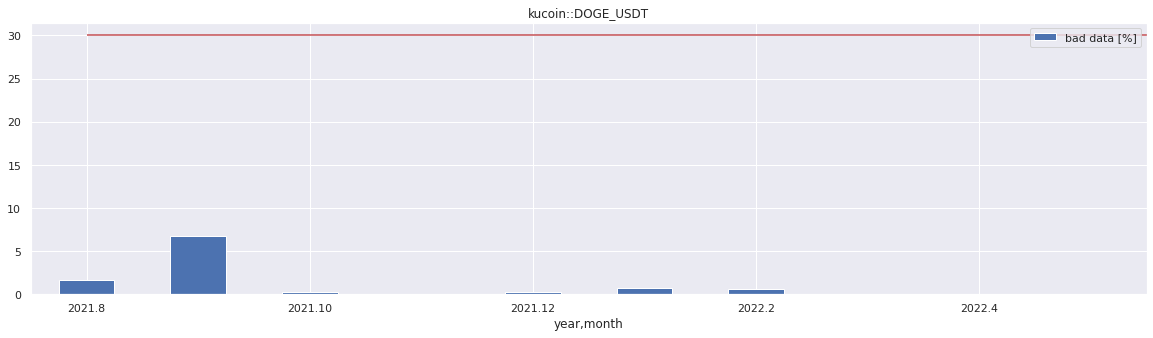

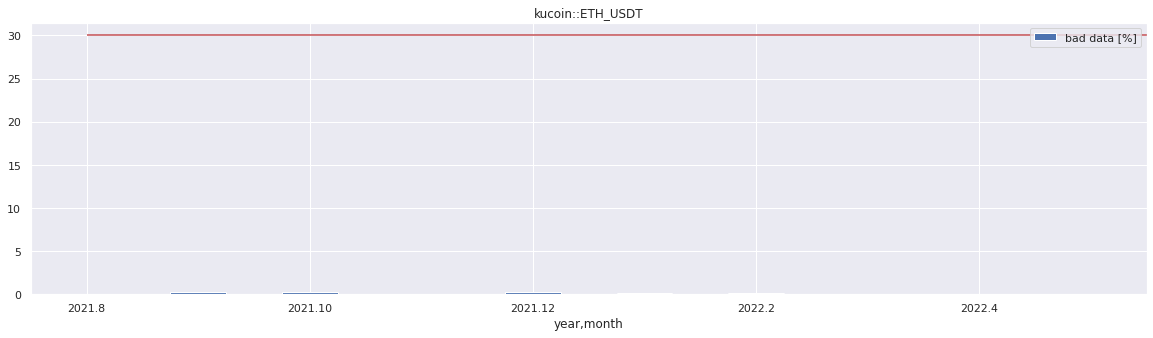

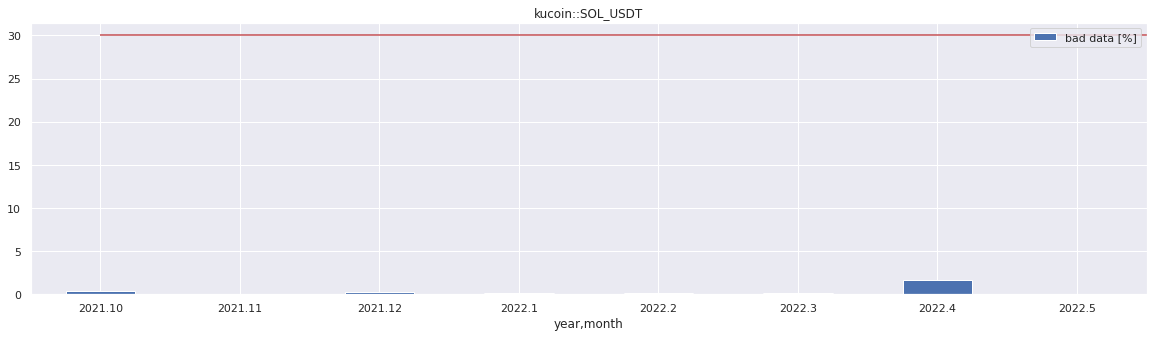

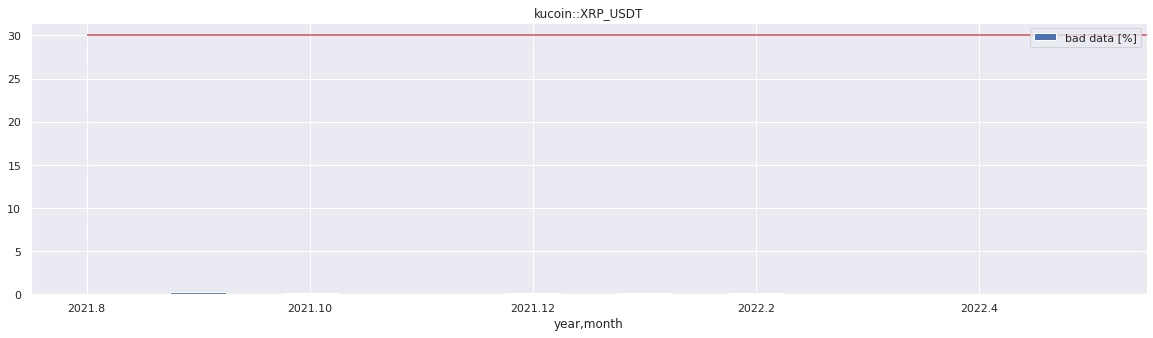

In [19]:
_ = _plot_bad_data_stats(config, kucoin_stats_by_year_month)

# Summary

- There is no `volume = 0` rows at all
- Binance:
   - Data is acceptable
   - All coins have  <1% of NaNs
- FTX:
   - NaN spikes for `DOGE` and `XRP` in 2022
   - Other coins are of decent quality
- Gateio:
   - Data is acceptable
   - All coins have  <2% of NaNs
- Kucoin:
   - Data is acceptable
   - All coins have  <2% of NaNs